In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score

We have a dataset collected from two days in 2013 from European credit card holders.  The dataset contains 284,807 transactions, of which only 0.172% (492) are fraudulent so the two classes are highly unbalanced.  There are 30 numeric inputs, including time (in seconds), transacting amount, and 28 other inputs that have been anonymized using dimension reduction algorithm PCA due to confidentiality issues.  

In [4]:
df = pd.read_csv('creditcard.csv')
print ('Number of transactions: ', df.shape[0])
print ('Number of inputs: ', df.shape[1])
df.head()

Number of transactions:  284807
Number of inputs:  31


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
print ('The number of days these transactions span: ', df['Time'].max()/(3600*24))

The number of days these transactions span:  1.99990740741


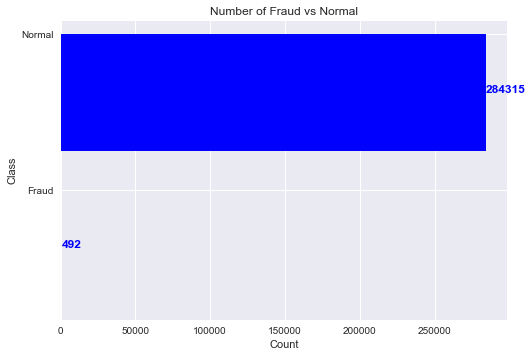

In [6]:
x = ['Fraud', 'Normal']
y = [sum(df['Class']==1), sum(df['Class']==0)]

fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="blue")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('Number of Fraud vs Normal')
plt.xlabel('Count')
plt.ylabel('Class')
for i, v in enumerate(y):
    ax.text(v + 3, i , str(v), color='blue', fontweight='bold')

Let's take a look at the distribution of inputs Time, Amount, and the first three annonymized inputs.  Bars in red represent fraud, and bars in green represent normal transactions. 

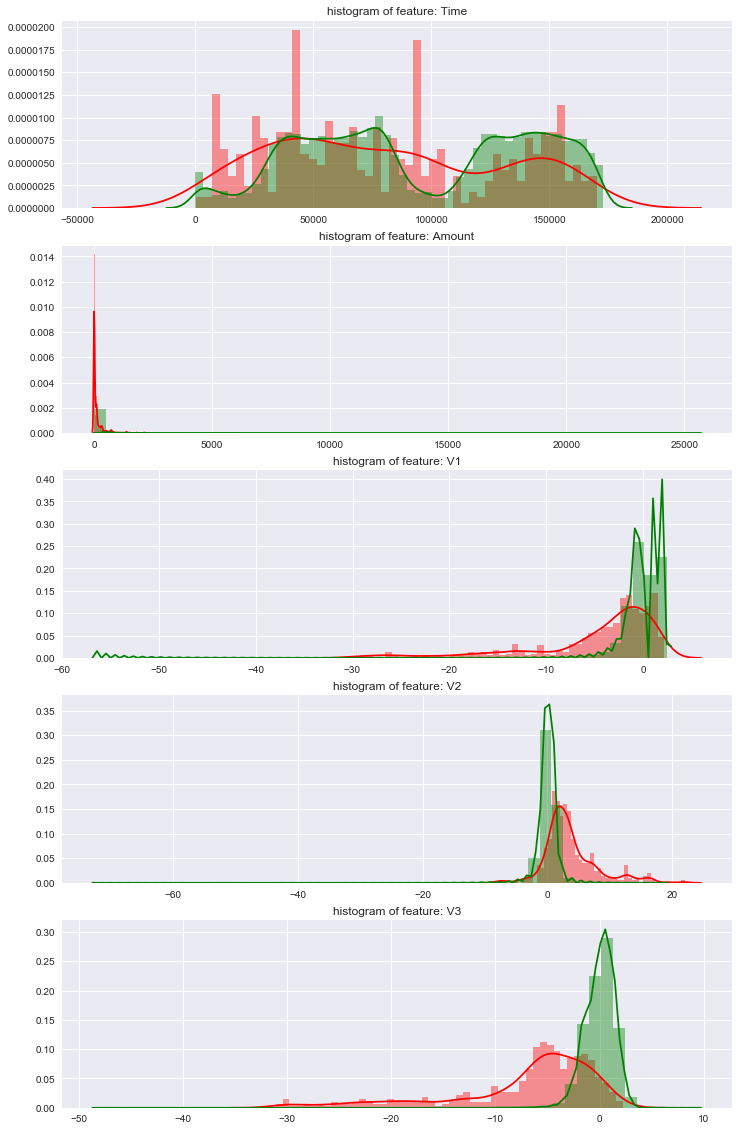

In [7]:
plt.figure(figsize=(12,5*4))
gs = gridspec.GridSpec(5, 1)
col_names = ['Time', 'Amount', 'V1', 'V2', 'V3']
for i, cn in enumerate(col_names):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Class == 1], bins=50, color='red')
    sns.distplot(df[cn][df.Class == 0], bins=50, color='green')
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

We can see that time seems to have a seasonal trend for normal transactions.  While fraud seems to occur more uniformly throughout.  So maybe we can find fraudulent transactions easier during off-peak hours.  
Fraudulent transactions seem to all have very small amount compare to normal transactions.
We see a difference in distributions between fraud and normal transactions in the three anonymized inputs as well.  
Perhaps we can find some patterns here that can help us identify fraud.  Deep Learning excel at discovering complex patterns within data, which is why it's so widely used in image identification and voice recognition.  So perhaps we can deploy Deep Learning here as well to predict the class label.  

We will split the data into train and test.

In [21]:
training_inputs, test_inputs, training_target, test_target\
= train_test_split(df.drop('Class', axis=1), df['Class'], test_size = .2, random_state=2)

We will also normalized the inputs to have mean of 0 and standard deviation of 1 to increase model accuracy.

In [22]:
features = training_inputs.columns.values
for feature in features:
    mean, std = df[feature].mean(), df[feature].std()
    training_inputs.loc[:, feature] = (training_inputs[feature] - mean) / std
    test_inputs.loc[:, feature] = (test_inputs[feature] - mean) / std

In [23]:
training_inputs.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
136700,-0.273476,-0.320061,0.710219,1.154571,0.613086,0.011175,-0.578718,0.822388,-0.446667,-0.386571,...,0.023126,0.095628,0.508677,-0.102161,1.212090,-0.577967,-1.041087,-0.929422,-0.246044,-0.273307
43219,-1.124362,-0.003098,-1.747664,-0.504228,0.064567,-1.222531,-0.645379,0.504839,-0.348600,-0.595996,...,1.910824,0.795835,-0.005248,-1.283519,0.749050,0.910274,-0.290900,-0.390059,0.394504,2.649808
18819,-1.369223,-0.271361,0.370609,1.106351,0.905241,0.339163,0.019286,0.727610,-0.256865,0.230143,...,0.220539,-0.198022,0.328590,-0.117160,0.109449,-0.299933,-0.588283,-0.054332,-0.743296,-0.270588
174557,0.571788,0.913644,-0.337076,-1.012280,0.242934,0.146465,0.088727,-0.183992,-0.003303,0.885316,...,0.288263,-0.419293,-1.560485,0.295105,-0.700375,-0.966757,0.277943,-0.122509,0.020534,0.276509
120641,-0.398202,0.640315,-0.064365,-0.582258,0.217749,1.438459,2.858775,-0.553066,0.785942,0.378925,...,-0.063433,-0.187375,-0.399574,-0.212050,1.681499,1.654477,-0.586077,0.106751,0.047032,-0.344033


In [24]:
test_inputs.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
225184,1.038704,-0.296861,0.575463,0.076463,-0.978034,1.005881,-1.197713,1.714395,-0.601961,-0.186788,...,-0.379793,0.208952,0.904708,-0.823418,0.127499,1.412337,-0.627234,-0.631422,-0.382567,-0.301973
116637,-0.430526,0.350606,-0.475735,0.623307,1.042917,-0.862943,-0.145004,-0.176190,-0.009903,0.661888,...,0.503967,0.378421,0.578314,-0.503319,0.705640,0.818629,-0.592168,0.056749,0.241872,0.671839
99414,-0.583448,-0.433143,0.735364,0.629755,-0.021291,-0.128619,-0.639400,0.359093,0.309007,-0.914939,...,0.103292,0.280356,0.761270,-0.103841,0.974300,-0.521387,0.573257,0.539700,0.386946,-0.287500
217619,0.971845,-0.563878,0.373614,-0.579700,-0.220952,-0.066736,-0.015480,1.149843,0.370308,-0.370099,...,0.664003,0.360784,0.604651,0.662622,1.072862,-0.158736,1.079529,0.374359,0.657102,0.726253
279878,1.565467,1.052734,-0.069495,-0.711890,0.301625,-0.166420,-0.931574,0.098598,-0.237226,0.618881,...,-0.369063,-0.407798,-1.064257,0.564931,0.034939,-0.633897,0.411656,-0.189838,-0.187544,-0.348071


Further split training into train and validation.

In [25]:
x_train, x_val, y_train, y_val = train_test_split(training_inputs, training_target, test_size = .15, random_state= 2)

In [26]:
print (x_train.shape, y_train.shape, x_val.shape, y_val.shape, test_inputs.shape, test_target.shape)

(193668, 30) (193668,) (34177, 30) (34177,) (56962, 30) (56962,)


In [27]:
# number of fraud in training set
print (sum(y_train.as_matrix() ==1))

347


There are only 347 fraud cases in training.  It's easier for our model to predict normal for all transactions.  So we will do upsampling when training the model, then test the result on validation and test data to see if upsampling imporved recall score.
We are going to increase the number of fraud cases in training using Synthetic Minority Over-sampling Technique, which uses k-nearest-neighbors to create similar but randomly tweeked cases of the minority class.

In [28]:
sm = SMOTE(random_state=2, ratio = 1.0)
x_train_up, y_train_up = sm.fit_sample(x_train.as_matrix(), y_train.as_matrix())

C:\Users\LuanJiang\Anaconda2\envs\py35\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


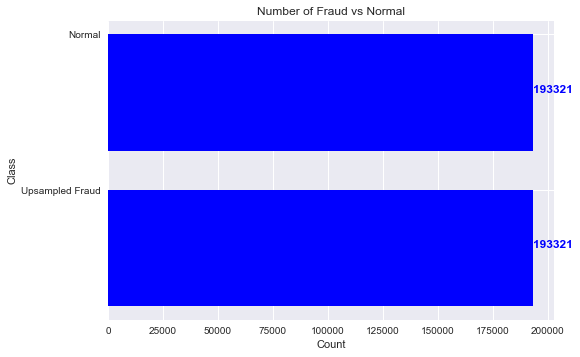

In [29]:
x = ['Upsampled Fraud', 'Normal']
y = [sum(y_train_up==1), sum(y_train_up==0)]

fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="blue")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('Number of Fraud vs Normal')
plt.xlabel('Count')
plt.ylabel('Class')
for i, v in enumerate(y):
    ax.text(v + 3, i , str(v), color='blue', fontweight='bold')

Now our class labels in training are balanced. 

However, SMOTE algorithm has the transactions in sequence according to the label. So we have to shuffle the training data to prevent our model from predicting using the sequence.

In [40]:
y_train_up

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [39]:
pd_up = pd.concat([pd.DataFrame(x_train_up),pd.DataFrame(y_train_up)], axis= 1)
mx_up_shuffled = shuffle(pd_up).as_matrix()
y_train_up_shuffled = mx_up_shuffled[:, -1]
x_train_up_shuffled = mx_up_shuffled[:, 0:-1]

In [42]:
y_train_up_shuffled

array([ 1.,  0.,  0., ...,  0.,  0.,  0.])

Now we convert the inputs into matrix and labels into one-hot-encoding so our model can ingest the data.

In [47]:
num_labels = 2
inputX = x_train_up_shuffled.astype(np.float32)
inputY = np.eye(num_labels)[y_train_up_shuffled.astype(np.int)].astype(np.float32)
inputX_valid = x_val.as_matrix().astype(np.float32)
inputY_valid = np.eye(num_labels)[y_val.as_matrix()].astype(np.float32)
inputX_test = test_inputs.as_matrix().astype(np.float32)
inputY_test = np.eye(num_labels)[test_target.as_matrix()].astype(np.float32)

Now we can define some of the parameters for the model we are about to train.  (These values were selected after grid search with different combinations of parameters).

In [71]:
batch_size = 74
num_nodes = 20
num_features = inputX.shape[1]
keep_prob =0.9
learning_rate = 0.004
training_epochs = 2000
num_samples = inputX.shape[0]

This is how the model performance will be measured. 

In [67]:
def accuracy(predictions, labels):
    return (100.0*np.sum(np.argmax(predictions,1) ==np.argmax(labels, 1)) / predictions.shape[0])

In [86]:
def recall(labels, predictions):
    tp = np.sum((np.argmax(predictions,1)==1) & (np.argmax(labels, 1)==1))
    fn = np.sum((np.argmax(predictions,1)==0) & (np.argmax(labels, 1)==1))
    return (100.0*tp/(tp+fn))

In [89]:
def precision(labels, predictions):
    tp = np.sum((np.argmax(predictions,1)==1) & (np.argmax(labels, 1)==1))
    fp = np.sum((np.argmax(predictions,1)==1) & (np.argmax(labels, 1)==0))
    return (100.0*tp/(tp+fp))

Below we will demonstrate the model with the best result, which is a deep neural network with 3 hidden layers, one dropout layer, and use RELU as its activation function.  Due to the high inbalance in data, we chose to use F1 score as the training stopping criteria, which is the weighted average of precision and recall.

In [91]:
# best result: 3 hidden layers, dropout, no regularization, relu as activation
graph= tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, \
                                     shape =(batch_size, num_features))
    tf_train_labels = tf.placeholder(tf.float32, shape =(batch_size, num_labels))
    tf_valid_dataset = tf.constant(inputX_valid)
    tf_test_dataset = tf.constant(inputX_test)
    
    #input
    weights1 = tf.Variable(tf.truncated_normal([num_features, num_nodes], stddev = 0.15))
    biases1 = tf.Variable(tf.zeros(num_nodes))
    hidden1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    # layer2
    weights2 = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], stddev = 0.15))
    biases2 = tf.Variable(tf.zeros([num_nodes]))
    hidden2 = tf.nn.relu(tf.matmul(hidden1, weights2) + biases2)
    hidden2 = tf.nn.dropout(hidden2, keep_prob=keep_prob)
    # layer 3
    weights3 = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], stddev = 0.15)) 
    biases3 = tf.Variable(tf.zeros([num_nodes]))
    hidden3 = tf.nn.relu(tf.matmul(hidden2, weights3) + biases3)

    # layer 4 / output
    weights4 = tf.Variable(tf.truncated_normal([num_nodes, num_labels], stddev = 0.15)) 
    biases4 = tf.Variable(tf.zeros([num_labels]))
    logits = tf.matmul(hidden3, weights4)+biases4
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels= tf_train_labels, logits = logits))
    
    #optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    # output
    train_prediction = tf.nn.softmax(logits)
    #validation
    logits1_valid = tf.matmul(tf_valid_dataset, weights1) + biases1
    sig1_valid = tf.nn.relu(logits1_valid)
    logits2_valid = tf.matmul(sig1_valid, weights2)+ biases2
    sig2_valid = tf.nn.relu(logits2_valid)
    logits3_valid = tf.matmul(sig2_valid, weights3) + biases3
    sig3_valid = tf.nn.relu(logits3_valid)
    logits4_valid = tf.matmul(sig3_valid, weights4) + biases4
    valid_prediction = tf.nn.softmax(logits4_valid)
    #test
    logits1_test = tf.matmul(tf_test_dataset, weights1) + biases1
    sig1_test = tf.nn.relu(logits1_test)
    logits2_test = tf.matmul(sig1_test, weights2)+ biases2
    sig2_test = tf.nn.relu(logits2_test)
    logits3_test = tf.matmul(sig2_test, weights3) + biases3
    sig3_test = tf.nn.relu(logits3_test)
    logits4_test = tf.matmul(sig3_test, weights4) + biases4
    test_prediction = tf.nn.softmax(logits4_test)


In [92]:
accuracy_summary = [] # Record accuracy 
recall_summary = [] # Record recall
precision_summary = []
f1_summary = []
valid_accuracy_summary = [] 
valid_recall_summary = []
valid_precision_summary = []
valid_f1_summary = []
stop_early = 0
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    print('Initialized')
    for epoch in range(training_epochs): 
        for batch in range(int(num_samples/batch_size)):
            batch_data = inputX[batch*batch_size : (1+batch)*batch_size]
            batch_labels = inputY[batch*batch_size : (1+batch)*batch_size]

            _,l, predictions = sess.run(
            [optimizer, loss, train_prediction], feed_dict={tf_train_dataset:batch_data, tf_train_labels:batch_labels})
        if (epoch%10 == 0):
            print ("batch loss at epoch %d: %f" % (epoch, l))
            train_accuracy = accuracy(predictions, batch_labels)
            print ("batch accuracy: %.6f%%" % train_accuracy)
            train_recall = recall(batch_labels, predictions)
            train_precision = precision(batch_labels, predictions)
            train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall)
            print ("batch f1 score: %.6f%%" % train_f1)
            
            valid_prediction_result = valid_prediction.eval()
            valid_accuracy = accuracy(valid_prediction_result, inputY_valid)
            print ("validation accuracy: %.6f%%" % valid_accuracy)
            valid_recall = recall(inputY_valid, valid_prediction_result)
            valid_precision = precision(inputY_valid, valid_prediction_result)
            valid_f1 = 2 * (valid_precision * valid_recall) / (valid_precision + valid_recall)
            print ("validation f1 score: %.6f%%" % valid_f1)
            
            
            # Record the results of the model
            accuracy_summary.append(train_accuracy)
            recall_summary.append(train_recall)
            precision_summary.append(train_precision)
            f1_summary.append(train_f1)
            valid_accuracy_summary.append(valid_accuracy)
            valid_recall_summary.append(valid_recall)
            valid_precision_summary.append(valid_precision)
            valid_f1_summary.append(valid_f1)
            
            # If f1 score does not improve after 15 logs, stop the training.
            if valid_f1 < max(valid_f1_summary) and epoch > 100:
                stop_early += 1
                if stop_early == 15:
                    break
            else:
                stop_early = 0
            
    print()
    print("Optimization Finished!")
    test_prediction_result = test_prediction.eval()
    test_recall = recall(inputY_test, test_prediction_result)
    test_precision = precision(inputY_test, test_prediction_result)
    print ("test accuracy: %.6f%%" % accuracy(test_prediction_result, inputY_test))
    print ("test recall: %.6f%%" % test_recall)
    print ("test precision: %.6f%%" % test_precision)
    print ("test f1 score: %.6f%%" % (2 * (test_precision * test_recall) / (test_precision + test_recall)))
    print ("number of fraud in test set: " , sum(inputY_test[:,1]==1))
    print ("number of normal transactions in test set: " , sum(inputY_test[:,1]==0))
    print ("number of predicted fraud in test: ", sum(np.argmax(test_prediction_result, 1)==1))
    print ("number of predicted normal transactions in test: ", sum(np.argmax(test_prediction_result, 1)==0))
    print ("corrected predicted fraud in test: ", len([i for i in range(inputY_test.shape[0]) if np.argmax(inputY_test[i, :])==1 and np.argmax(test_prediction_result[i, :])==1]))
    

Initialized
batch loss at epoch 0: 0.141073
batch accuracy: 95.945946%
batch f1 score: 95.238095%
validation accuracy: 98.048395%
validation f1 score: 12.810458%
batch loss at epoch 10: 0.003633
batch accuracy: 100.000000%
batch f1 score: 100.000000%
validation accuracy: 99.365070%
validation f1 score: 32.398754%
batch loss at epoch 20: 0.003106
batch accuracy: 100.000000%
batch f1 score: 100.000000%
validation accuracy: 99.604998%
validation f1 score: 42.553191%
batch loss at epoch 30: 0.001689
batch accuracy: 100.000000%
batch f1 score: 100.000000%
validation accuracy: 99.713257%
validation f1 score: 50.505051%
batch loss at epoch 40: 0.001483
batch accuracy: 100.000000%
batch f1 score: 100.000000%
validation accuracy: 99.789332%
validation f1 score: 58.139535%
batch loss at epoch 50: 0.001205
batch accuracy: 100.000000%
batch f1 score: 100.000000%
validation accuracy: 99.812740%
validation f1 score: 60.493827%
batch loss at epoch 60: 0.000721
batch accuracy: 100.000000%
batch f1 sco

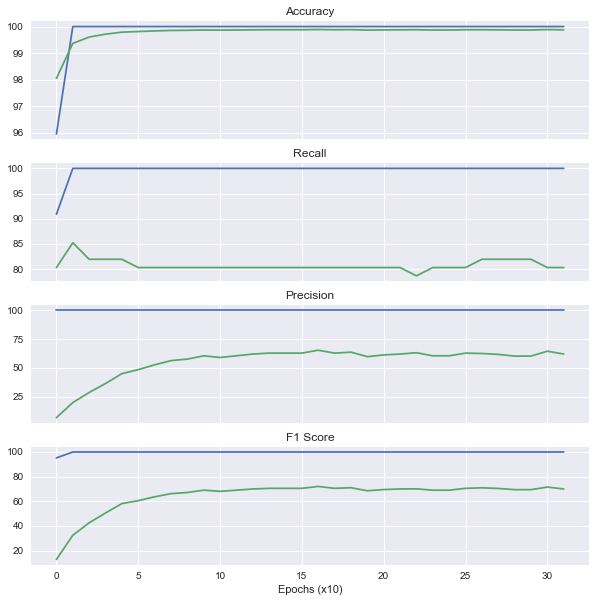

In [96]:
# Plot the model metrics
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(10,10))

ax1.plot(accuracy_summary) # blue
ax1.plot(valid_accuracy_summary) # green
ax1.set_title('Accuracy')

ax2.plot(recall_summary)
ax2.plot(valid_recall_summary)
ax2.set_title('Recall')

ax3.plot(precision_summary)
ax3.plot(valid_precision_summary)
ax3.set_title('Precision')

ax4.plot(f1_summary)
ax4.plot(valid_f1_summary)
ax4.set_title('F1 Score')

plt.xlabel('Epochs (x10)')
plt.show()

With this Deep Learning model, we achieved 83.3% recall, which is the percentage of corrected classified fraud out of the total number of true fraud.  Only 0.065% normal transactions were mistaken as fraud, which is pretty good.

How did we fare against a shallow classifier?

In [102]:
logreg = LogisticRegression()
logreg.fit(inputX,inputY[:,1])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [103]:
test_label_logreg = logreg.predict(inputX_test)

In [112]:
f1_score(inputY_test[:,1], test_label_logreg)

0.10461114934618032

In [114]:
clf = SVC()
clf.fit(inputX,inputY[:,1])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [116]:
test_label_svm = clf.predict(inputX_test)

In [117]:
f1_score(inputY_test[:,1], test_label_logreg)

0.10461114934618032